### Filtering SNPS from ipyrad

This notebook will filter SNPs called from ipyrad (and probably stacks and other RADseq pipelines).  The goal of filtering is to reduce individuals with low coverage and missing data and to remove loci that are not biallelic, have too many missing individuals, have very small minor allele frequencies, and lack sufficient sequencing depth.  We should can also remove SNPs that are closely linked to other SNPs, this step should be done last in order to
ensure that the linked SNP we keep passes our other filtering parameters.

**Input files**: an unfiltered snp file in vcf format

**Output files**: a filtered snp file in vcf format

**Modules needed**: vcftools, gzip

#### Set module versions, load modules and load packages

In [1]:
! module load vcftools/0.1.16
! module load gzip/1.12
vcftools = "vcftools"
gzip = "gzip"

import sys
import os
from os import environ
import gzip
import warnings
import pandas as pd
import numpy as np
import scipy as sp
import glob
import re
import random
import matplotlib.pyplot as plt

#### Set values for your directory, set input file name:

In [2]:
mydir = "/scratch/mw955/mive1/"

In [3]:
inputfile = "mive.vcf"

#### Create project dir, move into directory and move vcf file to project directory

If you haven't done the previous ipyrad step of this pipeline, just place your vcf file in the project directory

In [4]:
cd $mydir

/scratch/mw955/mive1


In [5]:
!mkdir filter

mkdir: cannot create directory ‘filter’: File exists


In [6]:
projdir = os.path.join(mydir,"filter")

In [7]:
cp ipyrad/mive_outfiles/mive.vcf filter

In [8]:
cd $projdir

/scratch/mw955/mive1/filter


4. Count number of SNPs in the unfiltered vcf

In [9]:
!cat $inputfile | grep -v '#' | wc -l

213663


## Filter for only biallelic SNPs

In [10]:
!module load vcftools/0.1.16

In [11]:
!module load vcftools/0.1.16 && \
vcftools --remove-indels \
--min-alleles 2 \
--max-alleles 2 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--vcf $inputfile \
--out biallelic


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf mive.vcf
	--recode-INFO-all
	--max-alleles 2
	--min-alleles 2
	--out biallelic
	--recode
	--remove-filtered-all
	--remove-indels

After filtering, kept 192 out of 192 Individuals
Outputting VCF file...
After filtering, kept 189277 out of a possible 213663 Sites
Run Time = 30.00 seconds


## Filter Loci by MAF and missing indviduals

In [12]:
!module load vcftools/0.1.16 && \
$vcftools \
--max-missing 0.6 \
--maf 0.02 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--vcf biallelic.recode.vcf \
--out filtered_loci


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf biallelic.recode.vcf
	--recode-INFO-all
	--maf 0.02
	--max-missing 0.6
	--out filtered_loci
	--recode
	--remove-filtered-all

After filtering, kept 192 out of 192 Individuals
Outputting VCF file...
After filtering, kept 18521 out of a possible 189277 Sites
Run Time = 8.00 seconds


## Remove individuals with large amounts of missing data

First we will get a report from vcftools of the number missing SNPs per individual

In [13]:
!module load vcftools/0.1.16 && \
vcftools \
--vcf filtered_loci.recode.vcf \
--missing-indv \
--recode \
--recode-INFO-all \
--out filtered_loci




Error: Only one output function may be called.



In [14]:
ls

allsnps                   snps.log
bad_indv.txt              snps.map
badindv.txt               snps.ped
badindv.txt.save          stats.imiss
badindv.txt.save.1        stats.log
biallelic.log             thinned.log
biallelic.recode.vcf      thinned.recode.vcf
filtered_indv.log         thinned.recode.vcf.frq
filtered_indv.recode.vcf  thinned.recode.vcf.frq.count
filtered_loci.imiss       thinned.recode.vcf.het
filtered_loci.log         thinned.recode.vcf.hwe
filtered_loci.recode.vcf  thinned.recode.vcf.idepth
freq.ifreqburden          thinned.recode.vcf.ldepth
freq.log                  thinned.recode.vcf.ldepth.mean
imiss_stats.imiss         thinned.recode.vcf.lmiss
imiss_stats.log           thinned.recode.vcf.log
mive.vcf                  thinned.recode.vcf.lqual
out.imiss                 thinned_depth.idepth
out.log                   thinned_depth.log
snps.012                  thinned_final.log
snps.012.indv             thinned_final.recode.vcf
snps.012.pos              {snps_gz}.lo

**Examine the report to come up with a cut off for missing data:**

In [15]:
imiss_df = pd.read_csv("filtered_loci.imiss", sep="\t")
imiss_df.index = imiss_df.INDV

In [16]:
imiss_df.head()

,INDV,N_DATA,N_GENOTYPES_FILTERED,N_MISS,F_MISS
INDV,,,,,
100AZ5,100AZ5,18521,0,1254,0.067707
101AZ6,101AZ6,18521,0,1262,0.068139
102AZ7,102AZ7,18521,0,8025,0.433292
103AZ8,103AZ8,18521,0,2219,0.119810
104AZ9,104AZ9,18521,0,2693,0.145403


In [17]:
imiss_df.F_MISS.describe()

count    192.000000
mean       0.194197
std        0.187218
min        0.036391
25%        0.070353
50%        0.112251
75%        0.265253
max        0.991091
Name: F_MISS, dtype: float64

array([[<Axes: title={'center': 'F_MISS'}>]], dtype=object)

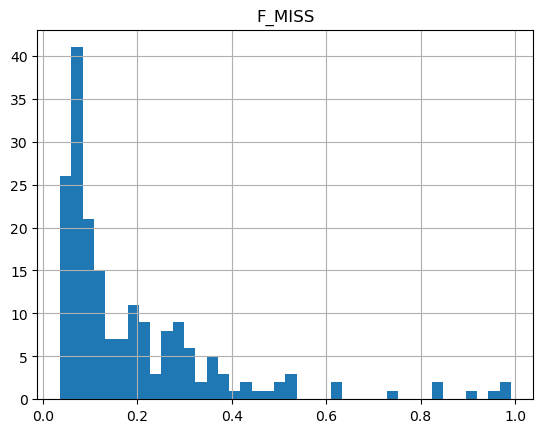

In [18]:
imiss_df.hist(column= "F_MISS", bins= 40)

**Based on the above figure I'm thinking we remove individuals missing more than 60% of the data.  Lets see how many individuals that is and which ones they are:**

In [19]:
len(imiss_df),len(imiss_df[imiss_df.F_MISS >= .4]),len(imiss_df[imiss_df.F_MISS >= .5]), len(imiss_df[imiss_df.F_MISS >= .6])


(192, 19, 13, 9)

In [20]:
bad_indv40 = imiss_df.INDV[imiss_df.F_MISS >= .4]
bad_indv50 = imiss_df.INDV[imiss_df.F_MISS >= .5]
bad_indv60 = imiss_df.INDV[imiss_df.F_MISS >= .6]

In [21]:
print(bad_indv40)

INDV
102AZ7      102AZ7
110ASU4    110ASU4
112ASU6    112ASU6
113ASU7    113ASU7
121SC        121SC
126SC        126SC
130MG        130MG
138DC        138DC
146VP        146VP
153AC        153AC
161GC        161GC
171MC        171MC
177MC        177MC
184FC        184FC
185FC        185FC
40DS          40DS
59UF          59UF
68BL          68BL
96AZ1        96AZ1
Name: INDV, dtype: object


In [22]:
print(bad_indv50)

INDV
112ASU6    112ASU6
113ASU7    113ASU7
121SC        121SC
130MG        130MG
138DC        138DC
146VP        146VP
153AC        153AC
161GC        161GC
177MC        177MC
184FC        184FC
185FC        185FC
68BL          68BL
96AZ1        96AZ1
Name: INDV, dtype: object


In [23]:
print(bad_indv60)

INDV
113ASU7    113ASU7
130MG        130MG
146VP        146VP
153AC        153AC
161GC        161GC
177MC        177MC
185FC        185FC
68BL          68BL
96AZ1        96AZ1
Name: INDV, dtype: object


**Ok, I think I'm going to remove individuals missing 50% of their data or more, this means I'm removing 13 individuals and retaining 179**

In [24]:
badindv = imiss_df.INDV[imiss_df.F_MISS >= .5]

In [25]:
badindv.to_csv("badindv.txt", header=False, index=False, sep="\t")

In [26]:
!cat badindv.txt

112ASU6
113ASU7
121SC
130MG
138DC
146VP
153AC
161GC
177MC
184FC
185FC
68BL
96AZ1


In [27]:
!module load vcftools/0.1.16 && \
vcftools \
--vcf filtered_loci.recode.vcf \
--remove badindv.txt \
--recode \
--recode-INFO-all \
--out filtered_indv


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf filtered_loci.recode.vcf
	--remove badindv.txt
	--recode-INFO-all
	--out filtered_indv
	--recode

Excluding individuals in 'exclude' list
After filtering, kept 179 out of 192 Individuals
Outputting VCF file...
After filtering, kept 18521 out of a possible 18521 Sites
Run Time = 7.00 seconds


In [28]:
ls

allsnps                   snps.log
bad_indv.txt              snps.map
badindv.txt               snps.ped
badindv.txt.save          stats.imiss
badindv.txt.save.1        stats.log
biallelic.log             thinned.log
biallelic.recode.vcf      thinned.recode.vcf
filtered_indv.log         thinned.recode.vcf.frq
filtered_indv.recode.vcf  thinned.recode.vcf.frq.count
filtered_loci.imiss       thinned.recode.vcf.het
filtered_loci.log         thinned.recode.vcf.hwe
filtered_loci.recode.vcf  thinned.recode.vcf.idepth
freq.ifreqburden          thinned.recode.vcf.ldepth
freq.log                  thinned.recode.vcf.ldepth.mean
imiss_stats.imiss         thinned.recode.vcf.lmiss
imiss_stats.log           thinned.recode.vcf.log
mive.vcf                  thinned.recode.vcf.lqual
out.imiss                 thinned_depth.idepth
out.log                   thinned_depth.log
snps.012                  thinned_final.log
snps.012.indv             thinned_final.recode.vcf
snps.012.pos              {snps_gz}.lo

## Thin SNPs so that there is only one SNP per RADtag

**From running fastqc, our RADtags are 122bp, so I'm going to use that as my thinning distance

In [29]:
!module load vcftools/0.1.16 && \
vcftools \
--vcf filtered_indv.recode.vcf \
--thin 122 \
--recode \
--recode-INFO-all \
--out thinned


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf filtered_indv.recode.vcf
	--recode-INFO-all
	--thin 122
	--out thinned
	--recode

After filtering, kept 179 out of 179 Individuals
Outputting VCF file...
After filtering, kept 5128 out of a possible 18521 Sites
Run Time = 5.00 seconds


In [30]:
ls

allsnps                   snps.log
bad_indv.txt              snps.map
badindv.txt               snps.ped
badindv.txt.save          stats.imiss
badindv.txt.save.1        stats.log
biallelic.log             thinned.log
biallelic.recode.vcf      thinned.recode.vcf
filtered_indv.log         thinned.recode.vcf.frq
filtered_indv.recode.vcf  thinned.recode.vcf.frq.count
filtered_loci.imiss       thinned.recode.vcf.het
filtered_loci.log         thinned.recode.vcf.hwe
filtered_loci.recode.vcf  thinned.recode.vcf.idepth
freq.ifreqburden          thinned.recode.vcf.ldepth
freq.log                  thinned.recode.vcf.ldepth.mean
imiss_stats.imiss         thinned.recode.vcf.lmiss
imiss_stats.log           thinned.recode.vcf.log
mive.vcf                  thinned.recode.vcf.lqual
out.imiss                 thinned_depth.idepth
out.log                   thinned_depth.log
snps.012                  thinned_final.log
snps.012.indv             thinned_final.recode.vcf
snps.012.pos              {snps_gz}.lo

##  Additional stats and filtering

## Heterozygosity

In [62]:
!module load vcftools/0.1.16 && \
vcftools \
--vcf thinned_final.recode.vcf \
--het \
--recode-INFO-all \
--out het


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf thinned_final.recode.vcf
	--recode-INFO-all
	--het
	--out het

stat error: No such file or directory
Error: Can't determine file type of thinned_final.recode.vcf


In [31]:
def get_vcf_stats(vcf):
    
    stats = ['depth',
            'site-depth',
            'site-mean-depth',
            'site-quality',
            'missing-site',
            'freq',
            'counts',
            'hardy',
            'het']
    
    for stat in stats:
        !module load vcftools && $vcftools \
        --vcf $vcf\
        --out $vcf \
        {"--%s" % stat} 

In [32]:
vcf = "thinned.recode.vcf"

In [33]:
get_vcf_stats(vcf)


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf thinned.recode.vcf
	--depth
	--out thinned.recode.vcf

After filtering, kept 179 out of 179 Individuals
Outputting Mean Depth by Individual
After filtering, kept 5128 out of a possible 5128 Sites
Run Time = 1.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf thinned.recode.vcf
	--out thinned.recode.vcf
	--site-depth

After filtering, kept 179 out of 179 Individuals
Outputting Depth for Each Site
After filtering, kept 5128 out of a possible 5128 Sites
Run Time = 0.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf thinned.recode.vcf
	--out thinned.recode.vcf
	--site-mean-depth

After filtering, kept 179 out of 179 Individuals
Outputting Depth for Each Site
After filtering, kept 5128 out of a possible 5128 Sites
Run Time = 1.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony M

In [34]:
ls

allsnps                   snps.log
bad_indv.txt              snps.map
badindv.txt               snps.ped
badindv.txt.save          stats.imiss
badindv.txt.save.1        stats.log
biallelic.log             thinned.log
biallelic.recode.vcf      thinned.recode.vcf
filtered_indv.log         thinned.recode.vcf.frq
filtered_indv.recode.vcf  thinned.recode.vcf.frq.count
filtered_loci.imiss       thinned.recode.vcf.het
filtered_loci.log         thinned.recode.vcf.hwe
filtered_loci.recode.vcf  thinned.recode.vcf.idepth
freq.ifreqburden          thinned.recode.vcf.ldepth
freq.log                  thinned.recode.vcf.ldepth.mean
imiss_stats.imiss         thinned.recode.vcf.lmiss
imiss_stats.log           thinned.recode.vcf.log
mive.vcf                  thinned.recode.vcf.lqual
out.imiss                 thinned_depth.idepth
out.log                   thinned_depth.log
snps.012                  thinned_final.log
snps.012.indv             thinned_final.recode.vcf
snps.012.pos              {snps_gz}.lo

**Functions to calclulate Fis, HWE, and Sequencing Depth:**

In [35]:
pd.set_option('display.max_columns', 100)

def get_MAF(row):
    try:
        return np.min([row.A1_freq, row.A2_freq])
    except:
        print(row)
        
def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def calculate_Fis(vals):
    try:
        data = [float(x) for x in vals.split("/")]
        assert len(data) == 3
        num_individuals = np.sum(data)
        total_alleles = 2*num_individuals
        a1_count = 2*data[0]
        a2_count = 2*data[2]
        het_count = data[1]
        a1_count += het_count
        a2_count += het_count
        a1_freq = a1_count/total_alleles
        a2_freq = a2_count/total_alleles
        assert a1_freq + a2_freq == 1.0
        He = 2 * a1_freq * a2_freq * get_correction(num_individuals)
        Ho = het_count/num_individuals
        Fis = 1 - (Ho/He)
        return Fis
    except:
        return -9

def combine_vcf_stats(filedir, prefix):
    
    hardy_files = !ls {filedir}/{prefix}.hwe
    hardy = pd.read_csv(hardy_files[0], sep="\t")

    hardy.columns = ['CHROM', 'POS', 'OBS(HOM1/HET/HOM2)', 'E(HOM1/HET/HOM2)', 'ChiSq_HWE',
       'P_HWE', 'P_HET_DEFICIT', 'P_HET_EXCESS']
    hardy.index = hardy.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_files = !ls {filedir}/{prefix}.l* | grep -v log
    loci_df = pd.concat([pd.read_csv(x, sep="\t", skiprows=0) for x in loci_files], axis=1)
    chrom_pos = loci_df.iloc[:,0:2]
    
    frq_files = !ls {filedir}/{prefix}.frq* | grep -v count
    frq_data = []
    h = open(frq_files[0])
    header = h.readline().strip().split()
    for line in h:
        frq_data.append(line.strip().split('\t'))

    header = ['CHROM', 'POS', 'N_ALLELES', 'N_CHR', 'A1_FREQ', "A2_FREQ"]
    frq_df = pd.DataFrame(frq_data)
    print(frq_df.columns)
    #frq_df = frq_df.drop([6,7],axis=1)
    frq_df.columns = header
    frq_df.index = frq_df.apply(lambda x: "%s-%s" % (x.CHROM, x.POS), axis=1)
    
    loci_df = loci_df.drop(['CHROM','CHR','POS'], axis=1)
    loci_df = pd.concat([chrom_pos, loci_df], axis=1)
    loci_df.index = loci_df.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_df = pd.concat([loci_df, frq_df, hardy], axis=1)
    loci_df["A1_allele"] = loci_df.apply(lambda row: row.A1_FREQ.split(":")[0], axis=1)
    loci_df["A2_allele"] = loci_df.apply(lambda row: row.A2_FREQ.split(":")[0], axis=1)
    
    loci_df["A1_freq"] = loci_df.apply(lambda row: float(row.A1_FREQ.split(":")[1]), axis=1)
    loci_df["A2_freq"] = loci_df.apply(lambda row: float(row.A2_FREQ.split(":")[1]), axis=1)
    
    loci_df['MAF'] = loci_df.apply(get_MAF, axis=1)
    loci_df = loci_df.drop(['CHROM', 'POS'], axis=1)
    
    loci_df['Fis'] = loci_df['OBS(HOM1/HET/HOM2)'].apply(calculate_Fis)
    
    return loci_df, frq_df, hardy

In [36]:
loci_df, frq_df, hardy = combine_vcf_stats(projdir, vcf)

RangeIndex(start=0, stop=6, step=1)


## Sequencing depth

In [37]:
loci_df.MEAN_DEPTH.describe()

count    5128.000000
mean       53.909934
std       154.191074
min         0.000000
25%        21.250000
50%        33.030700
75%        54.020950
max      3624.200000
Name: MEAN_DEPTH, dtype: float64

array([[<Axes: title={'center': 'MEAN_DEPTH'}>]], dtype=object)

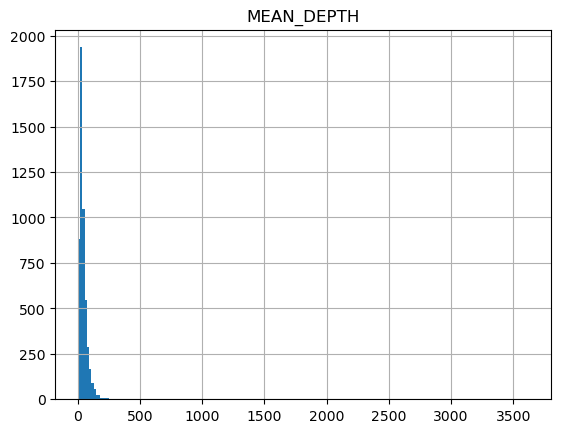

In [38]:
loci_df.hist(column= "MEAN_DEPTH", bins= 200)

In [39]:
loci_df.QUAL.describe()

count    5128.0
mean       13.0
std         0.0
min        13.0
25%        13.0
50%        13.0
75%        13.0
max        13.0
Name: QUAL, dtype: float64

In [40]:
# this would not be zero if there was an error in the calculation
len(loci_df[loci_df.Fis == -9])

0

In [41]:
len(loci_df[loci_df.MEAN_DEPTH > 30]),len(loci_df[loci_df.MEAN_DEPTH >= 3])

(2858, 5107)

In [42]:
 len(loci_df[loci_df.Fis <= -0.5]), len(loci_df[loci_df.MAF < 0.02])

(0, 162)

**Not sure if I'm calculating depth or quality correctly but I don't really like what I'm seeing here.  The other metrics look fine.  We can also calculate average depth for an individual:**

In [43]:
!module load vcftools && vcftools \
--vcf thinned.recode.vcf \
--out thinned_depth \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf thinned.recode.vcf
	--depth
	--out thinned_depth

After filtering, kept 179 out of 179 Individuals
Outputting Mean Depth by Individual
After filtering, kept 5128 out of a possible 5128 Sites
Run Time = 0.00 seconds


##  Hardy Weinberg across loci

In [44]:
ls


allsnps                   snps.log
bad_indv.txt              snps.map
badindv.txt               snps.ped
badindv.txt.save          stats.imiss
badindv.txt.save.1        stats.log
biallelic.log             thinned.log
biallelic.recode.vcf      thinned.recode.vcf
filtered_indv.log         thinned.recode.vcf.frq
filtered_indv.recode.vcf  thinned.recode.vcf.frq.count
filtered_loci.imiss       thinned.recode.vcf.het
filtered_loci.log         thinned.recode.vcf.hwe
filtered_loci.recode.vcf  thinned.recode.vcf.idepth
freq.ifreqburden          thinned.recode.vcf.ldepth
freq.log                  thinned.recode.vcf.ldepth.mean
imiss_stats.imiss         thinned.recode.vcf.lmiss
imiss_stats.log           thinned.recode.vcf.log
mive.vcf                  thinned.recode.vcf.lqual
out.imiss                 thinned_depth.idepth
out.log                   thinned_depth.log
snps.012                  thinned_final.log
snps.012.indv             thinned_final.recode.vcf
snps.012.pos              {snps_gz}.lo

In [45]:
hardy.P_HWE.describe()

count    5.128000e+03
mean     3.412829e-02
std      1.689459e-01
min      6.650912e-53
25%      4.284787e-17
50%      7.159920e-09
75%      1.496523e-06
max      1.000000e+00
Name: P_HWE, dtype: float64

In [46]:
ind_depth = os.path.join(projdir, "thinned_depth.idepth")
depth_df = pd.read_csv(ind_depth, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,100AZ5,5128,80.2168
1,101AZ6,5128,85.8042
2,102AZ7,5128,44.4729
3,103AZ8,5128,53.1966
4,104AZ9,5128,42.0998


In [47]:
depth_df.MEAN_DEPTH.describe()

count    179.000000
mean      53.909942
std       23.854544
min       13.863500
25%       33.406500
50%       52.106300
75%       71.195600
max      149.723000
Name: MEAN_DEPTH, dtype: float64

**This looks pretty good though**

## Output 012

In [48]:
!module load vcftools && vcftools \
--vcf thinned.recode.vcf \
--out snps \
--012


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf thinned.recode.vcf
	--012
	--out snps

After filtering, kept 179 out of 179 Individuals
Writing 012 matrix files ... Done.
After filtering, kept 5128 out of a possible 5128 Sites
Run Time = 1.00 seconds


In [49]:
ls


allsnps                   snps.log
bad_indv.txt              snps.map
badindv.txt               snps.ped
badindv.txt.save          stats.imiss
badindv.txt.save.1        stats.log
biallelic.log             thinned.log
biallelic.recode.vcf      thinned.recode.vcf
filtered_indv.log         thinned.recode.vcf.frq
filtered_indv.recode.vcf  thinned.recode.vcf.frq.count
filtered_loci.imiss       thinned.recode.vcf.het
filtered_loci.log         thinned.recode.vcf.hwe
filtered_loci.recode.vcf  thinned.recode.vcf.idepth
freq.ifreqburden          thinned.recode.vcf.ldepth
freq.log                  thinned.recode.vcf.ldepth.mean
imiss_stats.imiss         thinned.recode.vcf.lmiss
imiss_stats.log           thinned.recode.vcf.log
mive.vcf                  thinned.recode.vcf.lqual
out.imiss                 thinned_depth.idepth
out.log                   thinned_depth.log
snps.012                  thinned_final.log
snps.012.indv             thinned_final.recode.vcf
snps.012.pos              {snps_gz}.lo

## Output plink

In [50]:
!module load vcftools && vcftools \
--vcf thinned.recode.vcf \
--out snps \
--plink


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf thinned.recode.vcf
	--out snps
	--plink

After filtering, kept 179 out of 179 Individuals
Writing PLINK PED and MAP files ... 

Unrecognized values used for CHROM: RAD_2 - Replacing with 0.

Unrecognized values used for CHROM: RAD_5 - Replacing with 0.

Unrecognized values used for CHROM: RAD_40 - Replacing with 0.

Unrecognized values used for CHROM: RAD_48 - Replacing with 0.

Unrecognized values used for CHROM: RAD_61 - Replacing with 0.

Unrecognized values used for CHROM: RAD_62 - Replacing with 0.

Unrecognized values used for CHROM: RAD_76 - Replacing with 0.

Unrecognized values used for CHROM: RAD_90 - Replacing with 0.

Unrecognized values used for CHROM: RAD_124 - Replacing with 0.

Unrecognized values used for CHROM: RAD_130 - Replacing with 0.

Unrecognized values used for CHROM: RAD_134 - Replacing with 0.

Unrecognized values used for CHROM: RAD_139 - Replacing with 0.

Unreco

Unrecognized values used for CHROM: RAD_5220 - Replacing with 0.

Unrecognized values used for CHROM: RAD_5224 - Replacing with 0.

Unrecognized values used for CHROM: RAD_5250 - Replacing with 0.

Unrecognized values used for CHROM: RAD_5262 - Replacing with 0.

Unrecognized values used for CHROM: RAD_5271 - Replacing with 0.

Unrecognized values used for CHROM: RAD_5277 - Replacing with 0.

Unrecognized values used for CHROM: RAD_5279 - Replacing with 0.

Unrecognized values used for CHROM: RAD_5286 - Replacing with 0.

Unrecognized values used for CHROM: RAD_5293 - Replacing with 0.

Unrecognized values used for CHROM: RAD_5294 - Replacing with 0.

Unrecognized values used for CHROM: RAD_5295 - Replacing with 0.

Unrecognized values used for CHROM: RAD_5307 - Replacing with 0.

Unrecognized values used for CHROM: RAD_5312 - Replacing with 0.

Unrecognized values used for CHROM: RAD_5324 - Replacing with 0.

Unrecognized values used for CHROM: RAD_5345 - Replacing with 0.

Unrecogniz

Unrecognized values used for CHROM: RAD_11429 - Replacing with 0.

Unrecognized values used for CHROM: RAD_11443 - Replacing with 0.

Unrecognized values used for CHROM: RAD_11452 - Replacing with 0.

Unrecognized values used for CHROM: RAD_11460 - Replacing with 0.

Unrecognized values used for CHROM: RAD_11475 - Replacing with 0.

Unrecognized values used for CHROM: RAD_11481 - Replacing with 0.

Unrecognized values used for CHROM: RAD_11491 - Replacing with 0.

Unrecognized values used for CHROM: RAD_11518 - Replacing with 0.

Unrecognized values used for CHROM: RAD_11529 - Replacing with 0.

Unrecognized values used for CHROM: RAD_11545 - Replacing with 0.

Unrecognized values used for CHROM: RAD_11576 - Replacing with 0.

Unrecognized values used for CHROM: RAD_11589 - Replacing with 0.

Unrecognized values used for CHROM: RAD_11608 - Replacing with 0.

Unrecognized values used for CHROM: RAD_11612 - Replacing with 0.

Unrecognized values used for CHROM: RAD_11651 - Replacing with

Unrecognized values used for CHROM: RAD_17059 - Replacing with 0.

Unrecognized values used for CHROM: RAD_17060 - Replacing with 0.

Unrecognized values used for CHROM: RAD_17088 - Replacing with 0.

Unrecognized values used for CHROM: RAD_17098 - Replacing with 0.

Unrecognized values used for CHROM: RAD_17140 - Replacing with 0.

Unrecognized values used for CHROM: RAD_17159 - Replacing with 0.

Unrecognized values used for CHROM: RAD_17176 - Replacing with 0.

Unrecognized values used for CHROM: RAD_17190 - Replacing with 0.

Unrecognized values used for CHROM: RAD_17198 - Replacing with 0.

Unrecognized values used for CHROM: RAD_17200 - Replacing with 0.

Unrecognized values used for CHROM: RAD_17208 - Replacing with 0.

Unrecognized values used for CHROM: RAD_17226 - Replacing with 0.

Unrecognized values used for CHROM: RAD_17230 - Replacing with 0.

Unrecognized values used for CHROM: RAD_17246 - Replacing with 0.

Unrecognized values used for CHROM: RAD_17267 - Replacing with

Unrecognized values used for CHROM: RAD_24217 - Replacing with 0.

Unrecognized values used for CHROM: RAD_24218 - Replacing with 0.

Unrecognized values used for CHROM: RAD_24219 - Replacing with 0.

Unrecognized values used for CHROM: RAD_24221 - Replacing with 0.

Unrecognized values used for CHROM: RAD_24224 - Replacing with 0.

Unrecognized values used for CHROM: RAD_24226 - Replacing with 0.

Unrecognized values used for CHROM: RAD_24227 - Replacing with 0.

Unrecognized values used for CHROM: RAD_24230 - Replacing with 0.

Unrecognized values used for CHROM: RAD_24232 - Replacing with 0.

Unrecognized values used for CHROM: RAD_24243 - Replacing with 0.

Unrecognized values used for CHROM: RAD_24246 - Replacing with 0.

Unrecognized values used for CHROM: RAD_24252 - Replacing with 0.

Unrecognized values used for CHROM: RAD_24262 - Replacing with 0.

Unrecognized values used for CHROM: RAD_24270 - Replacing with 0.

Unrecognized values used for CHROM: RAD_24271 - Replacing with

Unrecognized values used for CHROM: RAD_30187 - Replacing with 0.

Unrecognized values used for CHROM: RAD_30190 - Replacing with 0.

Unrecognized values used for CHROM: RAD_30191 - Replacing with 0.

Unrecognized values used for CHROM: RAD_30193 - Replacing with 0.

Unrecognized values used for CHROM: RAD_30197 - Replacing with 0.

Unrecognized values used for CHROM: RAD_30203 - Replacing with 0.

Unrecognized values used for CHROM: RAD_30208 - Replacing with 0.

Unrecognized values used for CHROM: RAD_30212 - Replacing with 0.

Unrecognized values used for CHROM: RAD_30213 - Replacing with 0.

Unrecognized values used for CHROM: RAD_30221 - Replacing with 0.

Unrecognized values used for CHROM: RAD_30222 - Replacing with 0.

Unrecognized values used for CHROM: RAD_30223 - Replacing with 0.

Unrecognized values used for CHROM: RAD_30224 - Replacing with 0.

Unrecognized values used for CHROM: RAD_30225 - Replacing with 0.

Unrecognized values used for CHROM: RAD_30236 - Replacing with

Done.
After filtering, kept 5128 out of a possible 5128 Sites
Run Time = 1.00 seconds


## Next step:  PCA

**make PCA folder and put plink in it

In [51]:
cd ..

/scratch/mw955/mive1


In [52]:
mkdir pca

mkdir: cannot create directory ‘pca’: File exists


In [53]:
cp filter/snps.* pca/

## make additional plink files (.raw) in plink

In [54]:
cd pca/

/scratch/mw955/mive1/pca


In [55]:
!module load mambaforge \
&& mamba create -n plink-env --yes\
&& mamba activate plink-env \
&& mamba install -c bioconda plink --yes \
&& plink --file snps --recode AD


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.4.2) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: []

Preparing transaction: done
Verifying transaction: done
Executing transaction: done

To activate

conda-forge/noarch   ━━━━━━━━━╸━━━━━━━━━━━━━   5.0MB /  ??.?MB @   4.7MB/s  0.7s[+] 1.2s
bioconda/linux-64    ━━━━━━━━━━╸━━━━━━━━━━━━   4.5MB /  ??.?MB @   4.2MB/s  1.2s
bioconda/noarch      ━╸━━━━━━━━━━━━━━━╸━━━━━   4.5MB /  ??.?MB @   4.1MB/s  1.2s
pkgs/main/linux-64   ━━━━━━━━━━━╸━━━━━━━━━━━   4.1MB /  ??.?MB @   3.8MB/s  1.2s
pkgs/r/noarch        ━━╸━━━━━━━━━━━━━━━╸━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s
conda-forge/linux-64 ━━━━━━╸━━━━━━━━━━━━━━━━ 352.7kB /  ??.?MB @ 317.1kB/s  0.4s
conda-forge/noarch   ━━━━━━━━━━━╸━━━━━━━━━━━   5.6MB /  ??.?MB @   5.0MB/s  0.8s[+] 1.3s
bioconda/linux-64    ━━━━━━━━━╸━━━━━━━━━━━━   4.5MB @   4.2MB/s             1.3s
bioconda/noarch      ━━━━━━━━━━━━━━━━━━━━━━   4.7MB @   4.2MB/s Finalizing  1.3s
pkgs/main/linux-64   ━━━━━━━━━━━╸━━━━━━━━━━   4.1MB @   3.8MB/s             1.3s
pkgs/r/noarch        ━╸━━━━━━━━━━━━━━━╸━━━━   0.0 B @  ??.?MB/s             0.2s
conda-forge/linux-64 ━━━━━╸━━━━━━━━━━━━━━━━ 352.7kB @ 317.1kB/s             0.5s
conda-forge/

conda-forge/linux-64 ━━━━━━━━━━━╸━━━━━━━━━━━  18.8MB /  ??.?MB @   5.1MB/s  2.9s[+] 3.8s
conda-forge/linux-64 ━━━━━━━╸━━━━━━━━━━━━━━━  19.7MB /  ??.?MB @   5.2MB/s  3.0s[+] 3.9s
conda-forge/linux-64 ━━━━━━━━━━╸━━━━━━━━━━━━  20.6MB /  ??.?MB @   5.3MB/s  3.1s[+] 4.0s
conda-forge/linux-64 ━━━━━━━━━━━━╸━━━━━━━━━━  21.6MB /  ??.?MB @   5.4MB/s  3.2s[+] 4.1s
conda-forge/linux-64 ━━━━━━━━━━━━━━╸━━━━━━━━  22.5MB /  ??.?MB @   5.5MB/s  3.3s[+] 4.2s
conda-forge/linux-64 ╸━━━━━━━━━━━━━━━╸━━━━━━  23.5MB /  ??.?MB @   5.6MB/s  3.4s[+] 4.3s
conda-forge/linux-64 ━━╸━━━━━━━━━━━━━━━╸━━━━  24.4MB /  ??.?MB @   5.7MB/s  3.5s[+] 4.4s
conda-forge/linux-64 ━━━━━╸━━━━━━━━━━━━━━━╸━  25.3MB /  ??.?MB @   5.8MB/s  3.6s[+] 4.5s
conda-forge/linux-64 ━━━━━━━╸━━━━━━━━━━━━━━━  26.2MB /  ??.?MB @   5.9MB/s  3.7s[+] 4.6s
conda-forge/linux-64 ━━━━━━━━━╸━━━━━━━━━━━━━  27.2MB /  ??.?MB @   6.0MB/s  3.8s[+] 4.7s
conda-forge/linux-64 ━━━━━━━━━━━╸━━━━━━━━━━━  28.1MB /  ??.?MB @   6.0MB/s  3.9s[+] 4.8s
conda-forge/linux-64 

In [56]:
ls

plink.log    plink.raw  snps.012.indv  snps.log  snps.ped
plink.nosex  snps.012   snps.012.pos   snps.map


In [57]:
ls

plink.log    plink.raw  snps.012.indv  snps.log  snps.ped
plink.nosex  snps.012   snps.012.pos   snps.map
